Import the packages

In [2]:
import numpy as np
import vector

Define masses of the parent and daughter particles (in $MeV/c^2$)

In [3]:
mp = 105.7 #muon
m1 = 0.511 #electron
m2 = 0.12*1e-6 #electron antineutrino is less than this
m3 = 0.12*1e-6 #muon neutrino is less than this

Sample $s_{12}$

In [4]:
#number of simulations
N = 100000

s12max = (mp-m3)**2
s12min = (m1+m2)**2
s12 = np.random.uniform(s12min,s12max,N)

Calculate magnitude of momentum of daughter particles in COM frame when the parent particle decays into $p_{12}$ and $p_3$

In [5]:
p3 = np.sqrt(s12**2+(m3**2-mp**2)**2-(2*s12*(m3**2+mp**2)))/(2*mp)


Sample Angles in the lab rest frame

In [6]:
cos_theta = np.random.uniform(-1,1,N)
phi = np.random.uniform(0,2*np.pi,N)
theta = np.arccos(cos_theta)

Spatial momentum components and energy of daughter particle $p_3$

In [7]:
p3x = p3*np.sin(theta)*np.cos(phi)
p3y = p3*np.sin(theta)*np.sin(phi)
p3z = p3*cos_theta

E3 = np.sqrt(m3**2+p3**2)

4-vector of daughter particle $p_3$

In [8]:
daughter3= vector.array(
    {
        "E": E3,
        "px": p3x,
        "py": p3y,
        "pz": p3z,
    }
)


Now we look at the decay of $p_{12}$ to $p_1$ and $p_2$

In [9]:
p12 = np.sqrt(m1**4+(m2**2-s12)**2-(2*(m1**2)*(m2**2+s12)))/(2*np.sqrt(s12))

cos_theta12 = np.random.uniform(-1,1,N)
phi12 = np.random.uniform(0,2*np.pi,N)
theta12 = np.arccos(cos_theta)

p12x = p12*np.sin(theta12)*np.cos(phi12)
p12y = p12*np.sin(theta12)*np.sin(phi12)
p12z = p12*cos_theta12

E1 = np.sqrt(m1**2+p12**2)
E2 = np.sqrt(m2**2+p12**2)

daughter1 = vector.array(
    {
        "E": E1,
        "px": p12x,
        "py": p12y,
        "pz": p12z,
    }
)

daughter2 = vector.array(
    {
        "E": E2,
        "px": -p12x,
        "py": -p12y,
        "pz": -p12z,
    }
)

This is all in the rest frame of $p_{12}$ so we Lorentz boost this to the rest frame of the parent particle.

Using conservation of energy, $E_{init} = m_p$ and $E_{f}=E_{12}+E_3$. Therefore $E_{12}=m_p-E_3$ and by conservation of spatial momentum, it has the negative signs of $p_3$'s spatial momentum.

In [10]:
daughter12 = vector.array({
    "E": mp - daughter3.E,
    "px": -daughter3.px,
    "py": -daughter3.py,
    "pz": -daughter3.pz,
})

boosted_1 = daughter1.boostCM_of_p4(daughter12)
boosted_2 = daughter2.boostCM_of_p4(daughter12)

#print("Daughter 1:", boosted_1[0:3])
#print("Daughter 2:", boosted_2[0:3])
#print("Daughter 3:", daughter3[0:3])


For some reason this led to some negative values for the boosted electron antineutrinos' energies so I instead just went with this method to prevent any negative energies.

In [11]:
daughter12 = daughter1+daughter2

boosted_1 = daughter1.boostCM_of_p4(daughter12)
boosted_2 = daughter2.boostCM_of_p4(daughter12)

We want to verify the kinematics make sense so we create a histogram

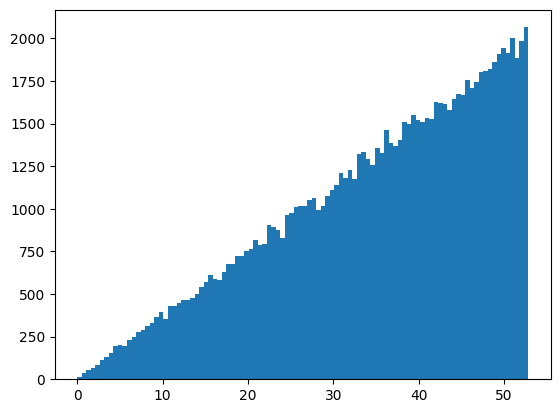

In [12]:
import matplotlib.pyplot as plt

energies2 = boosted_2.E
plt.hist(energies2, bins=100)
plt.show()

In [13]:
print(np.max(energies2))
print(np.min(energies2))

52.84854854723449
0.002649504718571732


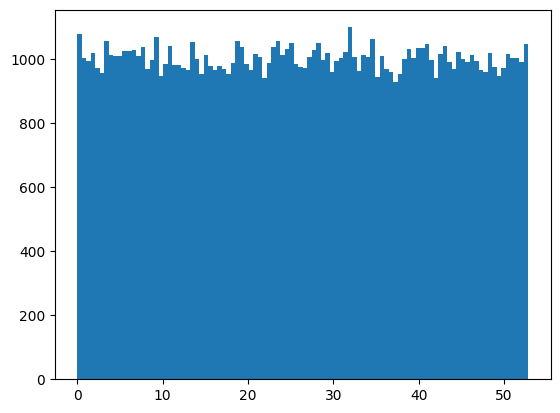

In [14]:
energies3 = daughter3.E
plt.hist(energies3, bins=100)
plt.show()

In [15]:
print(np.max(energies3))

52.848751925875256


Now let's make this a bit more realistic and add "weights" to this distribution to reflect the matrix element contributions. By https://arxiv.org/pdf/hep-ph/0203052, we can use equations 6 and 7 to weigh the electron antineutrino and muon neutrino distributions.

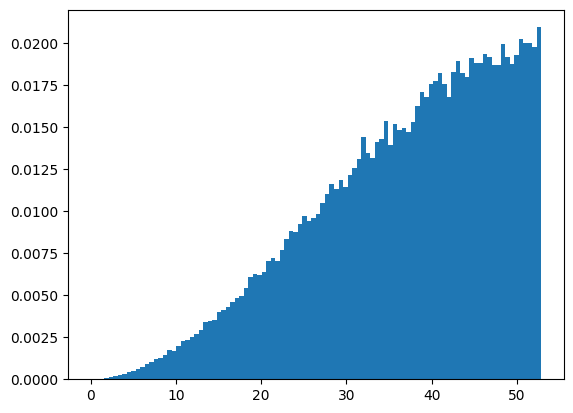

In [16]:
#muon neutrino

xmuon = 2*daughter3.E/mp
weight_muon = (xmuon**2)*(3.0-2*xmuon)

#normalize
tot_weight = np.sum(weight_muon)
norm_weight = weight_muon/tot_weight

plt.hist(daughter3.E,weights=norm_weight, bins=100)
plt.show()

In [17]:
print(np.max(daughter3.E))

52.848751925875256


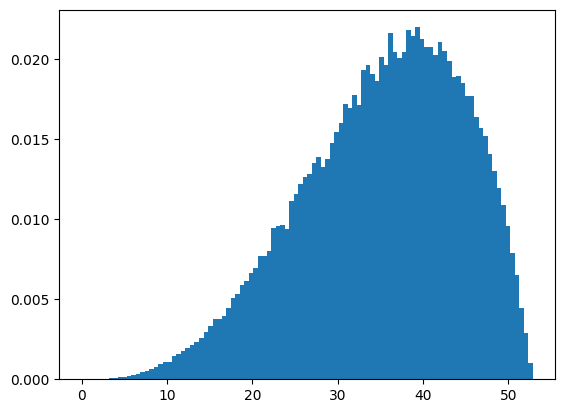

In [18]:
#electron antineutrino

xelec = 2*boosted_2.E/mp
weight_elec = (6*xelec**2)*(1-xelec)

#normalize
tot_weight_elec = np.sum(weight_elec)
norm_weight_elec = weight_elec/tot_weight_elec

plt.hist(boosted_2.E,weights=norm_weight_elec, bins=100)
plt.show()

Boosting now to have parent particle energy at 5 TeV. We can use the relativistic energy momentum equation ($E^2-p^2=m^2$) to find the relativistic momentum of this traveling muon and boost everything to this frame.

In [19]:
tot_energy = 5000000 #5 TeV
rel_mom = np.sqrt((tot_energy**2)-(mp**2))

parent = vector.array({
    "E": [tot_energy],
    "px": [rel_mom],
    "py": [0],
    "pz": [0],
}) #assume to be traveling along the x-axis

boosted_3 = daughter3.boost(parent)

print("Daughter 3:", boosted_3[0:3])

Daughter 3: [(1570715.72964087,  4.53426423, 14.33214438, 1570715.7297128 )
 (2959701.70303195, 34.4474444 , 10.55203201, 2959701.70325123)
 (2089793.32144583, 21.03800419, 32.22770345, 2089793.32180022)]


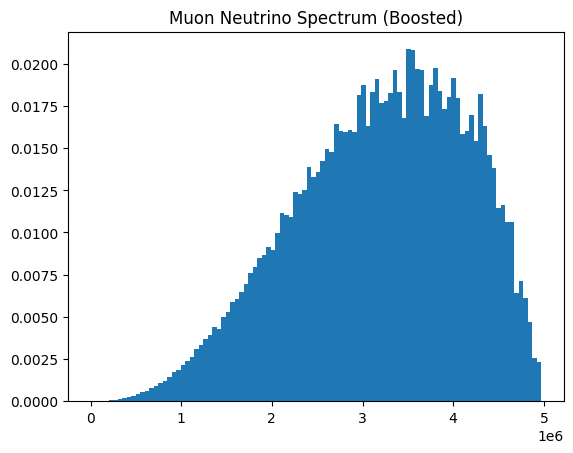

In [24]:
xmuon_b = 2*boosted_3.E/mp
weight_muon_b = (xmuon_b**2)*(3.0-2*xmuon_b)

#normalize
tot_weight_b = np.sum(weight_muon_b)
norm_weight_b = weight_muon_b/tot_weight_b

plt.hist(boosted_3.E,weights=norm_weight_b, bins=100)
plt.title("Muon Neutrino Spectrum (Boosted)")
plt.show()

In [21]:
#boost the boosted electron antineutrino
doub_boosted_2 = boosted_2.boost(parent)

print("Daughter 2 (boosted twice):", doub_boosted_2[0:3])

Daughter 2 (boosted twice): [( 600898.99905626,  2.49336198, -6.18602959,  600898.99980272)
 (2231412.84930343, -5.59114435, -9.65973113, 2231412.84931894)
 (1730528.77232693, 11.94171678, 20.36252057, 1730528.77251515)]


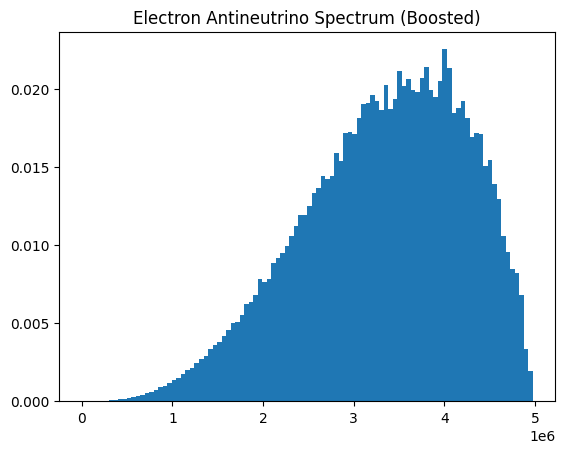

In [25]:
xelec_b = 2*doub_boosted_2.E/mp
weight_elec_b = (6*xelec_b**2)*(1-xelec_b)

#normalize
tot_weight_elec_b = np.sum(weight_elec_b)
norm_weight_elec_b = weight_elec_b/tot_weight_elec_b

plt.hist(doub_boosted_2.E,weights=norm_weight_elec_b, bins=100)

plt.title("Electron Antineutrino Spectrum (Boosted)")
plt.show()